In [1]:
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
X = pd.read_csv('X.csv')
X.shape

(768, 59)

In [4]:
with open('uncertain_features.txt', 'rb') as fp:
    uncertain_features = pickle.load(fp)

In [5]:
X = X[uncertain_features]

In [6]:
pandas_profiling.ProfileReport(X)

Number of variables,41
Number of observations,768
Total Missing (%),0.0%
Total size in memory,246.1 KiB
Average record size in memory,328.1 B
Numeric,41
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,2


In [7]:
dtypes = ['number']
df_numeric = X.loc[:, [col for col in X.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nPorcentaje_cero_cuotas_ope,nAmonestacion_suspension,D__U,nDesem_ult_semana,...,pregunta_30,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2
0,0,1,0,116,0,1,0.000000,0,1,0.256354,...,0.856284,0.554334,0.191990,0.880677,0.580707,0.754865,0.933387,0.445697,0.208157,0.014503
1,0,0,1,16,0,1,0.001969,0,1,0.406922,...,0.953864,0.296235,0.871500,2.061512,0.058207,0.708874,0.929419,0.018307,0.939968,0.343001
2,0,0,0,140,1,1,0.000000,0,1,0.321911,...,0.614530,0.867034,0.286807,0.668892,0.716495,0.907797,0.663385,0.478908,0.528751,0.528969
3,0,1,0,10,0,1,0.008791,0,1,0.294114,...,0.982207,0.249147,0.645303,0.722767,0.321391,0.337379,0.992835,0.330693,0.035893,0.494812
4,0,1,0,119,0,0,0.000000,0,1,0.315331,...,0.121376,0.003362,0.926111,0.000000,0.601921,0.110321,0.595219,0.767520,0.913815,0.833204


(768, 41)

['ingresoef',
 'D__Soltero',
 'D__Otros',
 'antiguedad',
 'D__Casado',
 'cero_cuotas',
 'nPorcentaje_cero_cuotas_ope',
 'nAmonestacion_suspension',
 'D__U',
 'nDesem_ult_semana',
 'D__ASESOR COMERCIAL JUNIOR 2',
 'pregunta_7',
 'nPorcentaje_sal_cero_cuo',
 'D__Femenino',
 'pregunta_12',
 'Edad',
 'pregunta_4',
 'pregunta_13',
 'pregunta_17',
 'pregunta_9',
 'pregunta_14',
 'nvarsaldocapital',
 'pregunta_10',
 'pregunta_11',
 'nEntidades_competencia',
 'pregunta_27',
 'pregunta_26',
 'pregunta_15',
 'pregunta_1',
 'pregunta_19',
 'pregunta_20',
 'pregunta_30',
 'pregunta_24',
 'pregunta_5',
 'nRatio_crec_deuda',
 'pregunta_3',
 'pregunta_18',
 'pregunta_22',
 'pregunta_16',
 'pregunta_6',
 'pregunta_2']

In [8]:
df_discrete = X.loc[:, [col for col in df_numeric.columns if (X[col].dropna() - X[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nAmonestacion_suspension,D__U,D__ASESOR COMERCIAL JUNIOR 2,D__Femenino,Edad,nEntidades_competencia
0,0,1,0,116,0,1,0,1,0,0,36,1
1,0,0,1,16,0,1,0,1,0,1,46,0
2,0,0,0,140,1,1,0,1,0,1,58,5
3,0,1,0,10,0,1,0,1,0,1,34,3
4,0,1,0,119,0,0,0,1,0,1,36,2


(768, 12)

['ingresoef',
 'D__Soltero',
 'D__Otros',
 'antiguedad',
 'D__Casado',
 'cero_cuotas',
 'nAmonestacion_suspension',
 'D__U',
 'D__ASESOR COMERCIAL JUNIOR 2',
 'D__Femenino',
 'Edad',
 'nEntidades_competencia']

In [9]:
df_continuous = X.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

,nPorcentaje_cero_cuotas_ope,nDesem_ult_semana,pregunta_7,nPorcentaje_sal_cero_cuo,pregunta_12,pregunta_4,pregunta_13,pregunta_17,pregunta_9,pregunta_14,...,pregunta_30,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2
0,0.000000,0.256354,0.007626,0.000000,0.422086,0.475461,0.809802,0.485178,0.767801,0.847675,...,0.856284,0.554334,0.191990,0.880677,0.580707,0.754865,0.933387,0.445697,0.208157,0.014503
1,0.001969,0.406922,0.929000,0.000141,0.654854,0.926026,0.164234,0.911706,0.014260,0.096512,...,0.953864,0.296235,0.871500,2.061512,0.058207,0.708874,0.929419,0.018307,0.939968,0.343001
2,0.000000,0.321911,0.501223,0.000000,0.134924,0.489488,0.052436,0.827381,0.388621,0.591681,...,0.614530,0.867034,0.286807,0.668892,0.716495,0.907797,0.663385,0.478908,0.528751,0.528969
3,0.008791,0.294114,0.909352,0.015452,0.701904,0.524197,0.933776,0.603548,0.602978,0.494228,...,0.982207,0.249147,0.645303,0.722767,0.321391,0.337379,0.992835,0.330693,0.035893,0.494812
4,0.000000,0.315331,0.609726,0.000000,0.247643,0.857995,0.829600,0.112340,0.383625,0.519680,...,0.121376,0.003362,0.926111,0.000000,0.601921,0.110321,0.595219,0.767520,0.913815,0.833204


(768, 29)

['nPorcentaje_cero_cuotas_ope',
 'nDesem_ult_semana',
 'pregunta_7',
 'nPorcentaje_sal_cero_cuo',
 'pregunta_12',
 'pregunta_4',
 'pregunta_13',
 'pregunta_17',
 'pregunta_9',
 'pregunta_14',
 'nvarsaldocapital',
 'pregunta_10',
 'pregunta_11',
 'pregunta_27',
 'pregunta_26',
 'pregunta_15',
 'pregunta_1',
 'pregunta_19',
 'pregunta_20',
 'pregunta_30',
 'pregunta_24',
 'pregunta_5',
 'nRatio_crec_deuda',
 'pregunta_3',
 'pregunta_18',
 'pregunta_22',
 'pregunta_16',
 'pregunta_6',
 'pregunta_2']

## Corr

In [10]:
def make_correlation_graphic(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

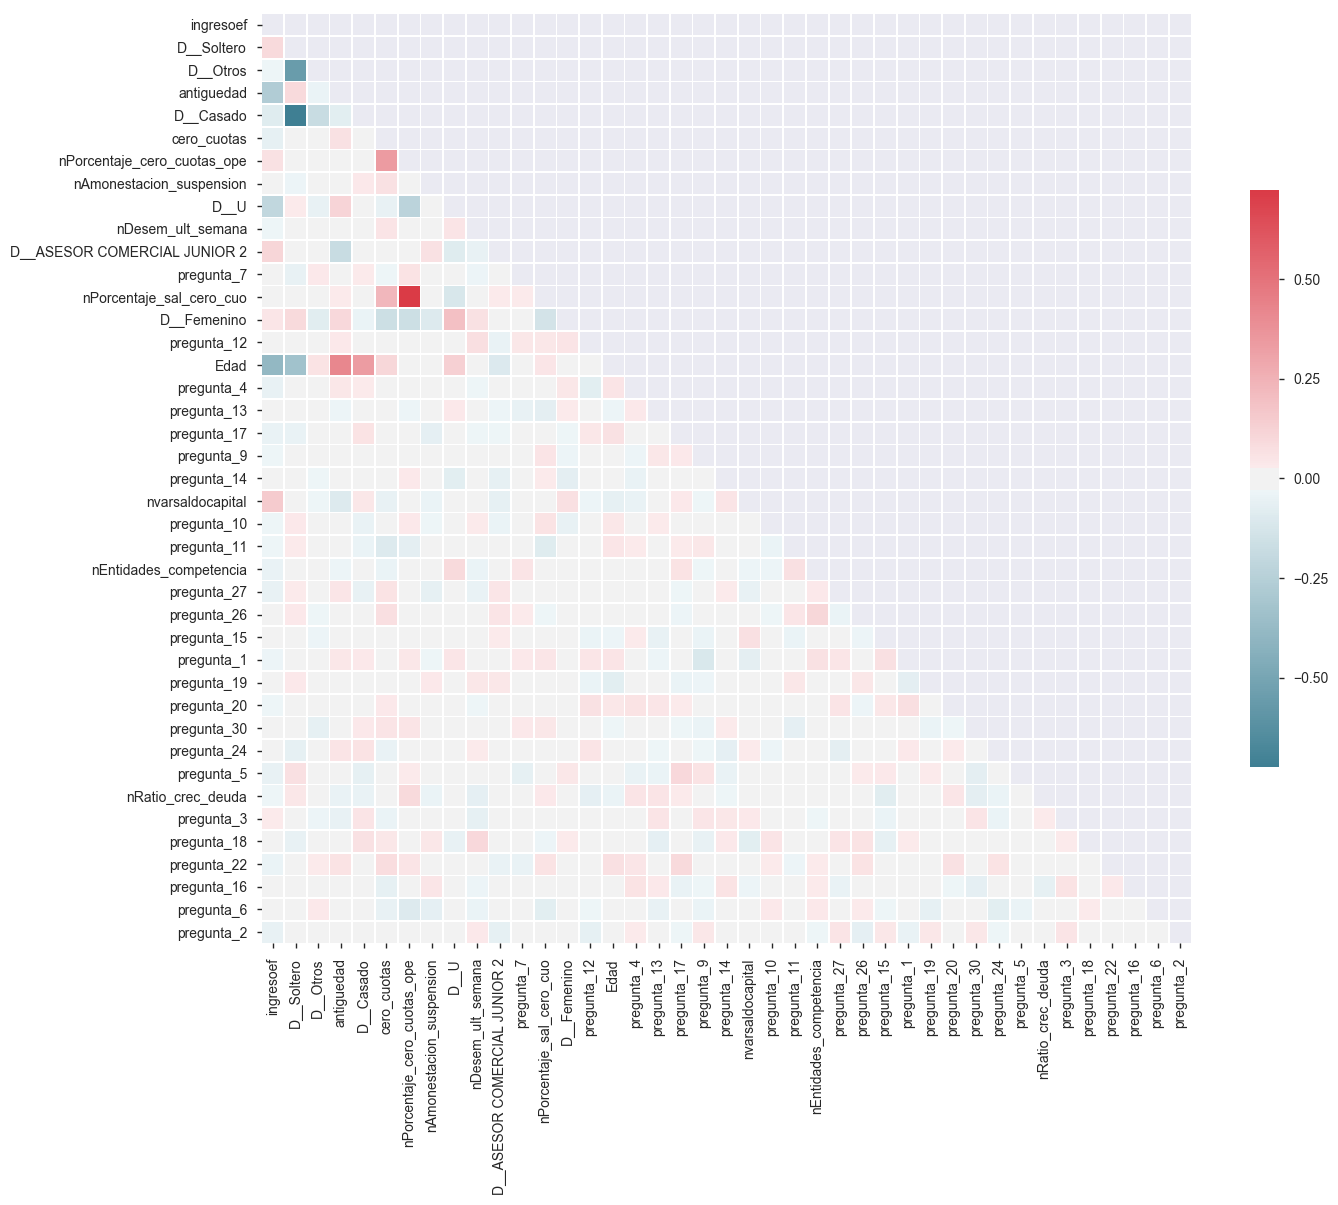

In [11]:
make_correlation_graphic(X)

# Creating target

In [12]:
y = pd.read_csv('y.csv', header=None)
y.shape

(768, 1)

In [13]:
y.columns = ['TARGET']

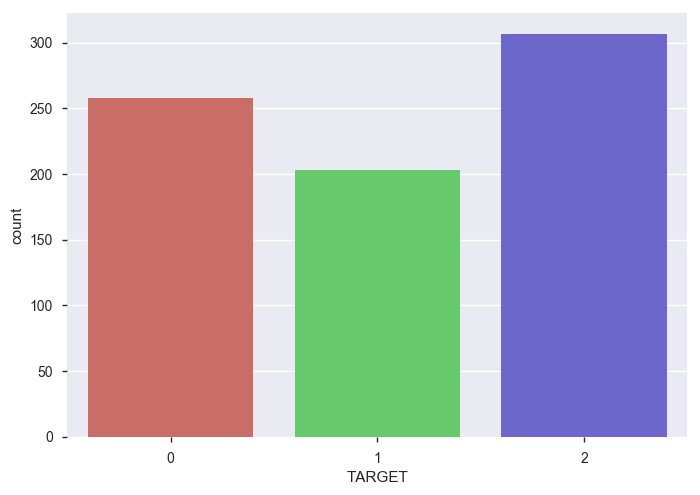

In [14]:
sns.countplot(x="TARGET", data=y, palette='hls')

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nPorcentaje_cero_cuotas_ope,nAmonestacion_suspension,D__U,nDesem_ult_semana,...,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2,cluster
0,0,1,0,116,0,1,0.000000,0,1,0.256354,...,0.554334,0.191990,0.880677,0.580707,0.754865,0.933387,0.445697,0.208157,0.014503,1
1,0,0,1,16,0,1,0.001969,0,1,0.406922,...,0.296235,0.871500,2.061512,0.058207,0.708874,0.929419,0.018307,0.939968,0.343001,-1
2,0,0,0,140,1,1,0.000000,0,1,0.321911,...,0.867034,0.286807,0.668892,0.716495,0.907797,0.663385,0.478908,0.528751,0.528969,-1
3,0,1,0,10,0,1,0.008791,0,1,0.294114,...,0.249147,0.645303,0.722767,0.321391,0.337379,0.992835,0.330693,0.035893,0.494812,0
4,0,1,0,119,0,0,0.000000,0,1,0.315331,...,0.003362,0.926111,0.000000,0.601921,0.110321,0.595219,0.767520,0.913815,0.833204,-1


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

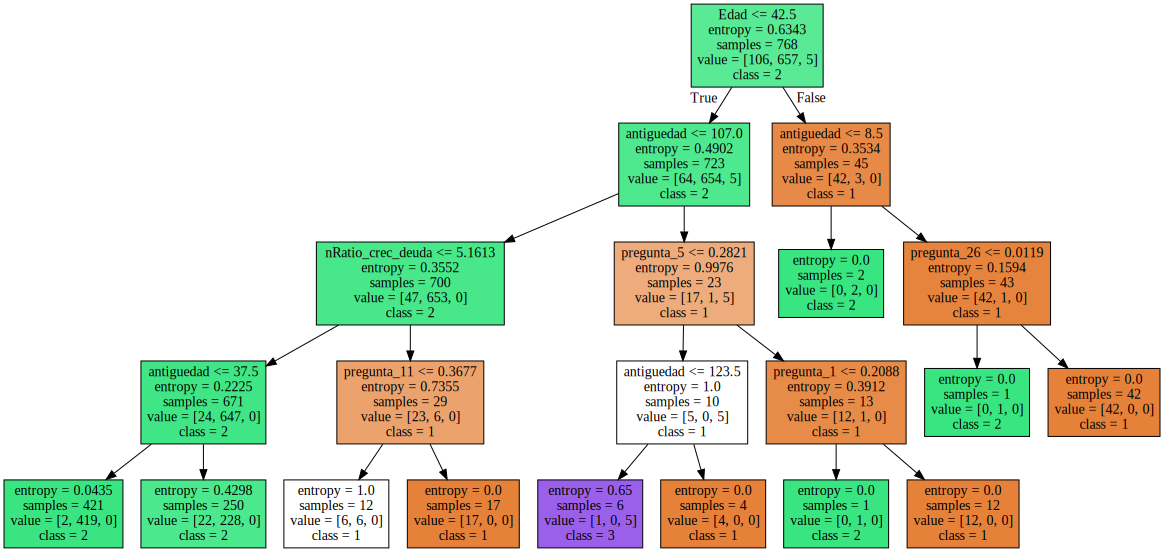

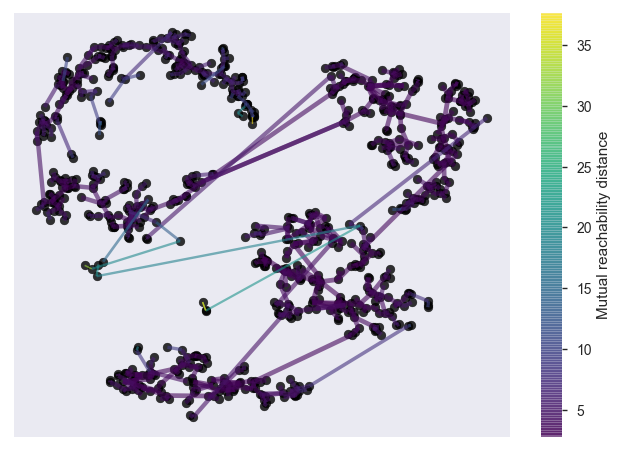

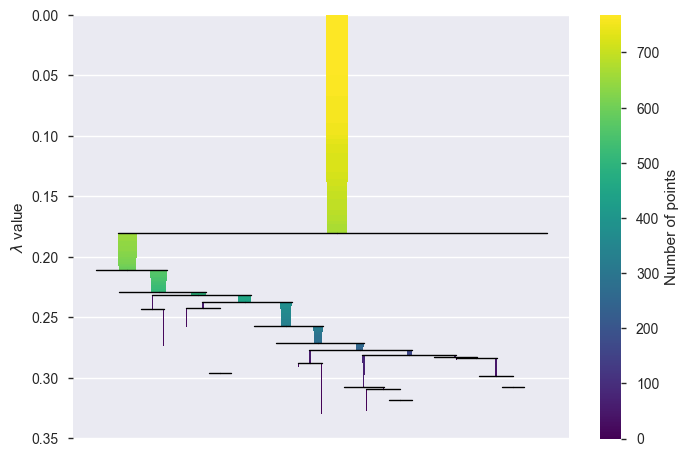

In [15]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

In [16]:
y = y['TARGET']

In [17]:
df = X
df['TARGET'] = y

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nPorcentaje_cero_cuotas_ope,nAmonestacion_suspension,D__U,nDesem_ult_semana,...,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2,TARGET
1,0,0,1,16,0,1,0.001969,0,1,0.406922,...,0.296235,0.871500,2.061512,0.058207,0.708874,0.929419,0.018307,0.939968,0.343001,2
3,0,1,0,10,0,1,0.008791,0,1,0.294114,...,0.249147,0.645303,0.722767,0.321391,0.337379,0.992835,0.330693,0.035893,0.494812,2
6,0,0,0,140,1,1,0.010038,0,1,0.075777,...,0.862505,0.073125,0.221226,0.042709,0.353595,0.708068,0.276790,0.387089,0.442683,2
12,0,0,0,119,1,0,0.000000,0,1,0.494248,...,0.915417,0.501630,0.939720,0.645230,0.730291,0.862811,0.627501,0.906539,0.448876,2
13,0,1,0,18,0,1,0.000000,0,1,0.229230,...,0.980667,0.429477,9.823684,0.738945,0.851035,0.017470,0.918613,0.107369,0.394757,2


1     1.0
3    -1.0
6    -1.0
12   -1.0
13    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

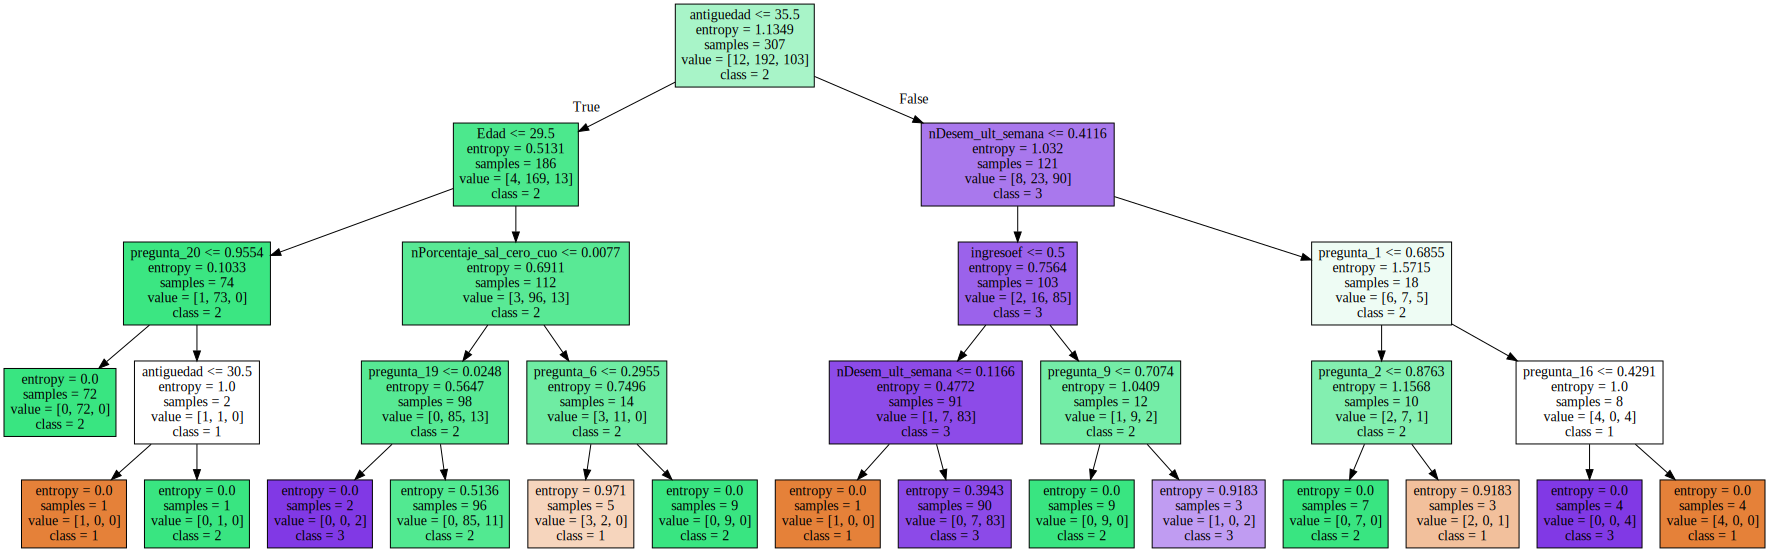

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nPorcentaje_cero_cuotas_ope,nAmonestacion_suspension,D__U,nDesem_ult_semana,...,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2,TARGET
0,0,1,0,116,0,1,0.000000,0,1,0.256354,...,0.554334,0.191990,0.880677,0.580707,0.754865,0.933387,0.445697,0.208157,0.014503,0
2,0,0,0,140,1,1,0.000000,0,1,0.321911,...,0.867034,0.286807,0.668892,0.716495,0.907797,0.663385,0.478908,0.528751,0.528969,0
8,0,0,1,104,0,1,0.016685,1,1,0.362352,...,0.604514,0.794239,0.972284,0.570358,0.984201,0.168664,0.298134,0.425821,0.217811,0
9,0,1,0,104,0,0,0.000000,0,1,0.221844,...,0.590105,0.941359,3.245267,0.718091,0.827901,0.906333,0.729381,0.259736,0.196752,0
11,0,0,0,76,1,1,0.003868,0,1,0.397763,...,0.817019,0.603140,0.912898,0.565522,0.995752,0.409242,0.441747,0.679366,0.730985,0


0    -1.0
2    -1.0
8    -1.0
9    -1.0
11    0.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

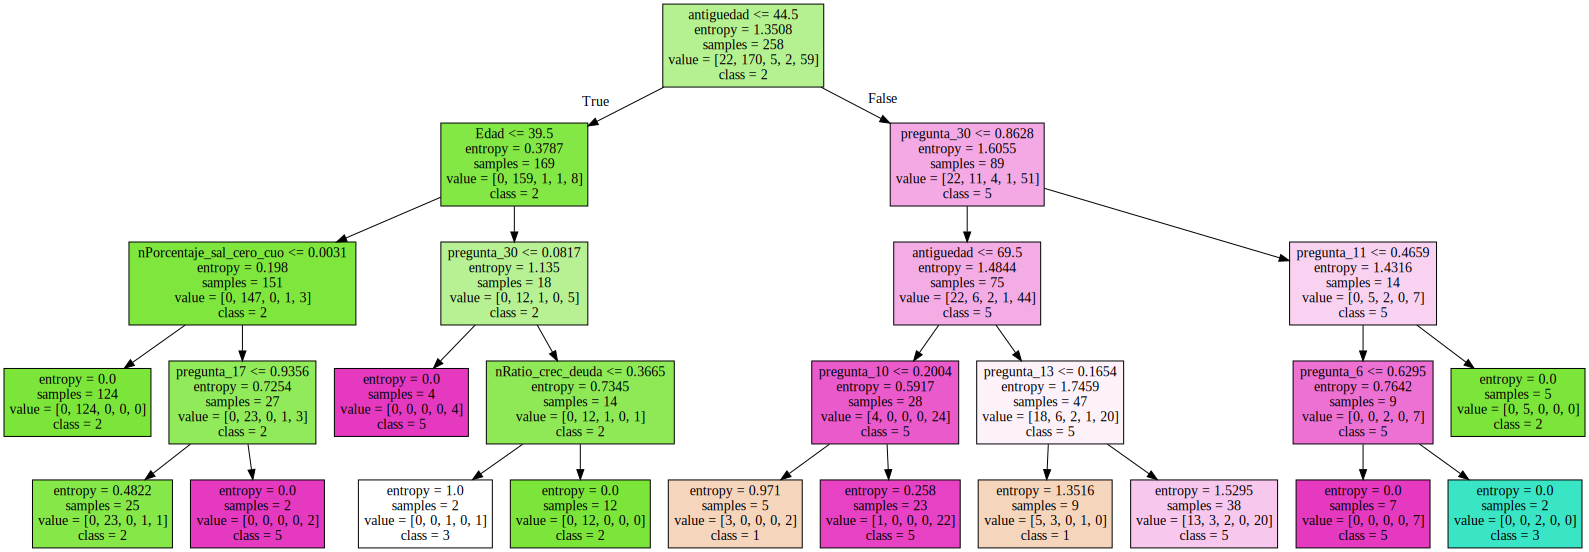

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ingresoef,D__Soltero,D__Otros,antiguedad,D__Casado,cero_cuotas,nPorcentaje_cero_cuotas_ope,nAmonestacion_suspension,D__U,nDesem_ult_semana,...,pregunta_24,pregunta_5,nRatio_crec_deuda,pregunta_3,pregunta_18,pregunta_22,pregunta_16,pregunta_6,pregunta_2,TARGET
4,0,1,0,119,0,0,0.000000,0,1,0.315331,...,0.003362,0.926111,0.000000,0.601921,0.110321,0.595219,0.767520,0.913815,0.833204,1
5,0,1,0,113,0,1,0.004474,0,1,0.351645,...,0.144056,0.434296,1.311511,0.613986,0.300183,0.479839,0.519179,0.976213,0.874347,1
7,0,1,0,104,0,0,0.000000,0,1,0.461129,...,0.047740,0.120059,8.502219,0.155432,0.424661,0.465298,0.478782,0.672811,0.787741,1
10,0,1,0,112,0,0,0.000000,0,1,0.284317,...,0.098871,0.585383,0.000000,0.386503,0.782912,0.068633,0.755217,0.706981,0.064413,1
15,0,1,0,11,0,1,0.000000,0,1,0.263154,...,0.204800,0.391220,0.829285,0.155241,0.083542,0.873054,0.884526,0.027578,0.129518,1


4     1.0
5    -1.0
7     0.0
10    0.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

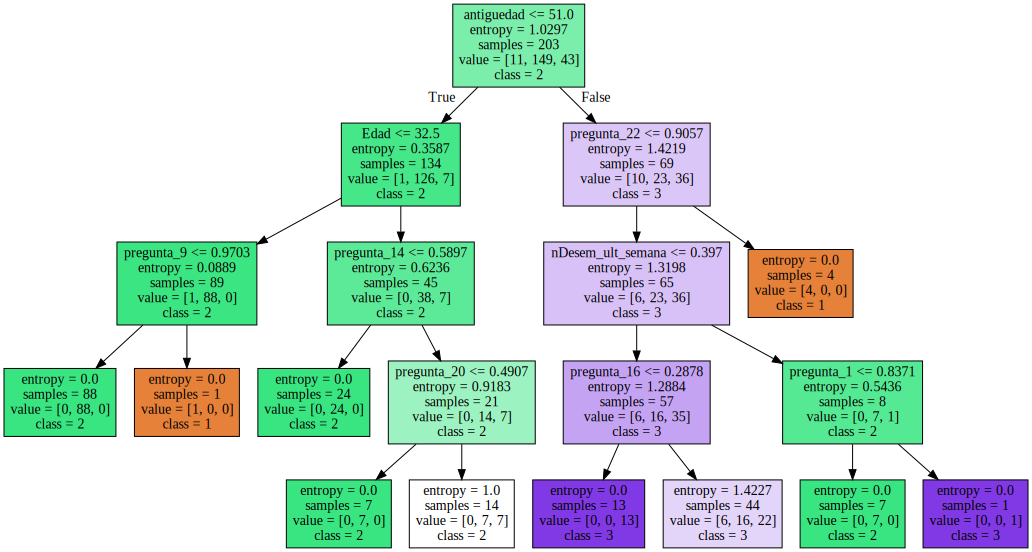

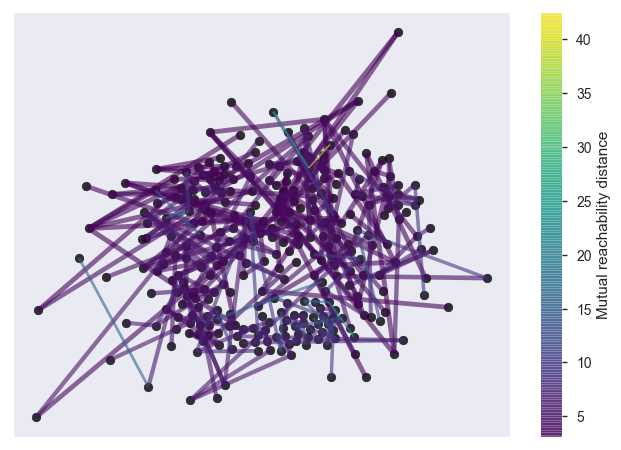

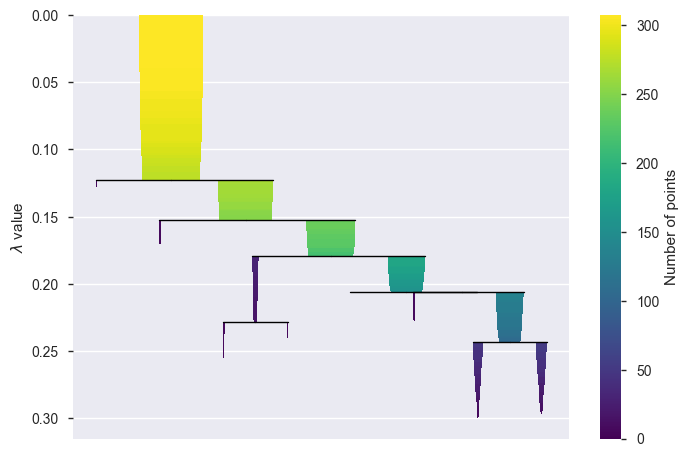

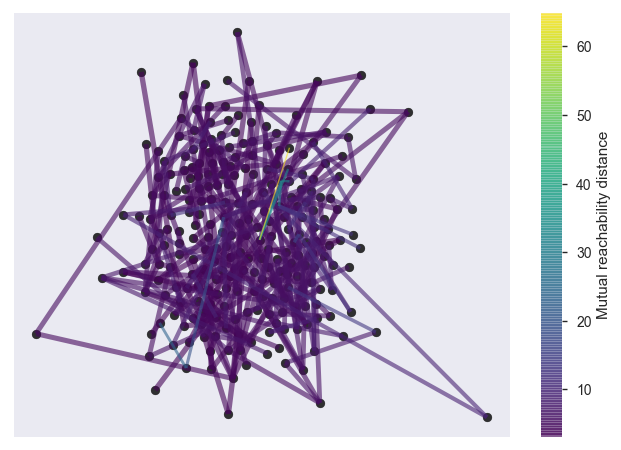

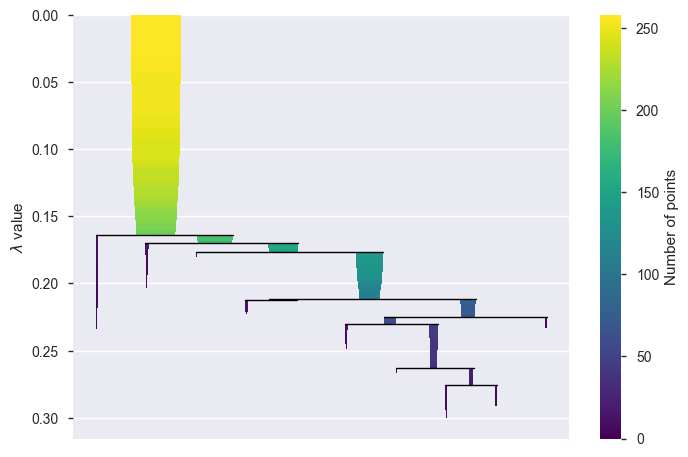

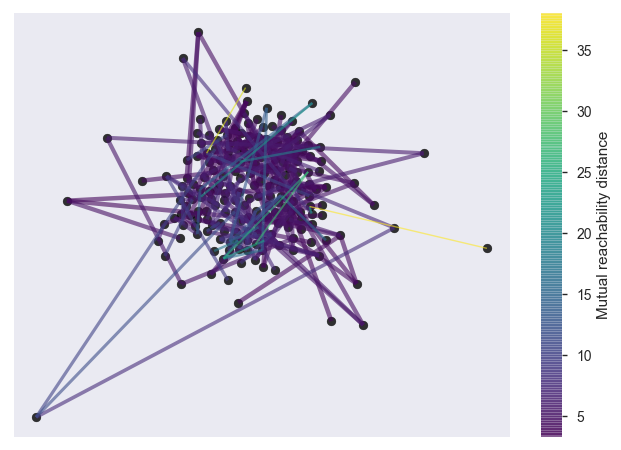

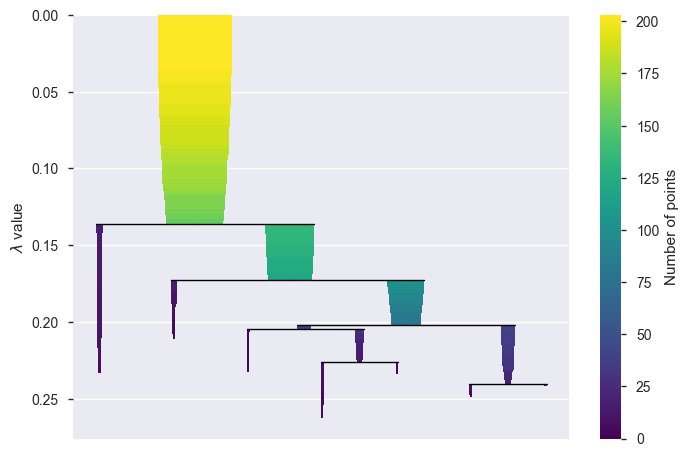

In [18]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

# Cross-validation

In [19]:
X = X.drop('TARGET', axis=1)

In [20]:
X.shape, y.shape

((768, 42), (768,))

In [21]:
eval_size = 0.1
kf = StratifiedKFold(y, round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [22]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 42), (690,))

((78, 42), (78,))

# Models

In [23]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [24]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'is_unbalance': False,
 'learning_rate': 0.02,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 30,
 'objective': 'multiclass',
 'reg_alpha': 1,
 'reg_lambda': 0,
 'seed': 777,
 'subsample': 0.6}

Recall: 0.45161290322580644
Precision: 0.5833333333333334
Accuracy: 0.4230769230769231


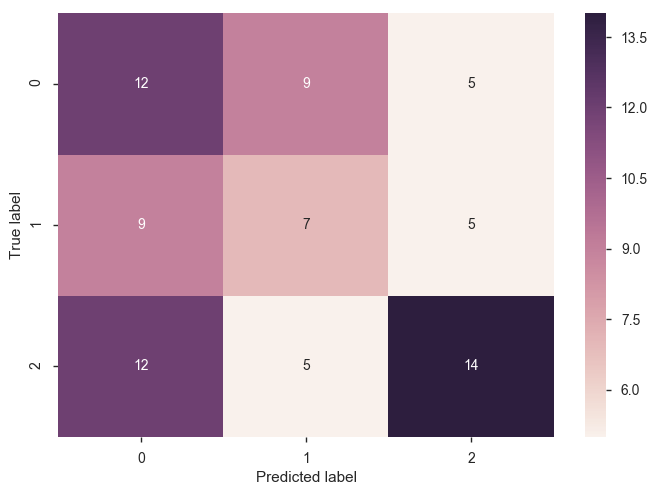

In [25]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09769
[2]	valid_0's multi_logloss: 1.09755
[3]	valid_0's multi_logloss: 1.09734
[4]	valid_0's multi_logloss: 1.09688
[5]	valid_0's multi_logloss: 1.0964
[6]	valid_0's multi_logloss: 1.09635
[7]	valid_0's multi_logloss: 1.09511
[8]	valid_0's multi_logloss: 1.09525
[9]	valid_0's multi_logloss: 1.09473
[10]	valid_0's multi_logloss: 1.09367
[11]	valid_0's multi_logloss: 1.09349
[12]	valid_0's multi_logloss: 1.0939
[13]	valid_0's multi_logloss: 1.09286
[14]	valid_0's multi_logloss: 1.09277
[15]	valid_0's multi_logloss: 1.09337
[16]	valid_0's multi_logloss: 1.0929
[17]	valid_0's multi_logloss: 1.09333
[18]	valid_0's multi_logloss: 1.09149
[19]	valid_0's multi_logloss: 1.09133
[20]	valid_0's multi_logloss: 1.09036
[21]	valid_0's multi_logloss: 1.0909
[22]	valid_0's multi_logloss: 1.08936
[23]	valid_0's multi_logloss: 1.0892
[24]	valid_0's multi_logloss: 1.08914
[25]	valid_0's multi_logloss: 1.08906
[26]	valid_0's multi_logloss: 1.08917
[27]	valid_0's multi_loglo

Recall: 0.3225806451612903
Precision: 0.38461538461538464
Accuracy: 0.358974358974359


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


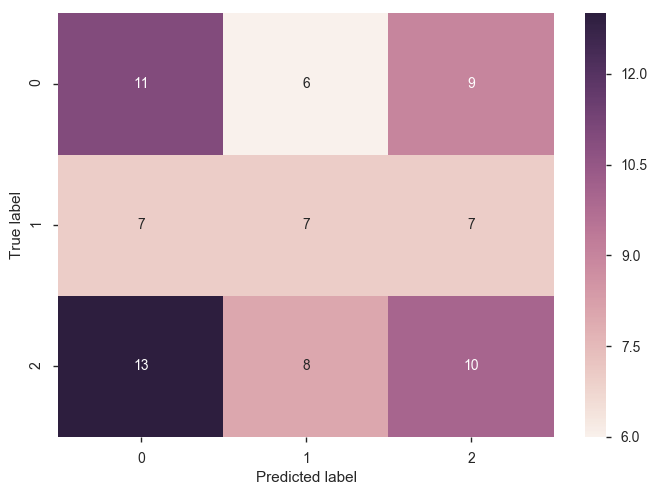

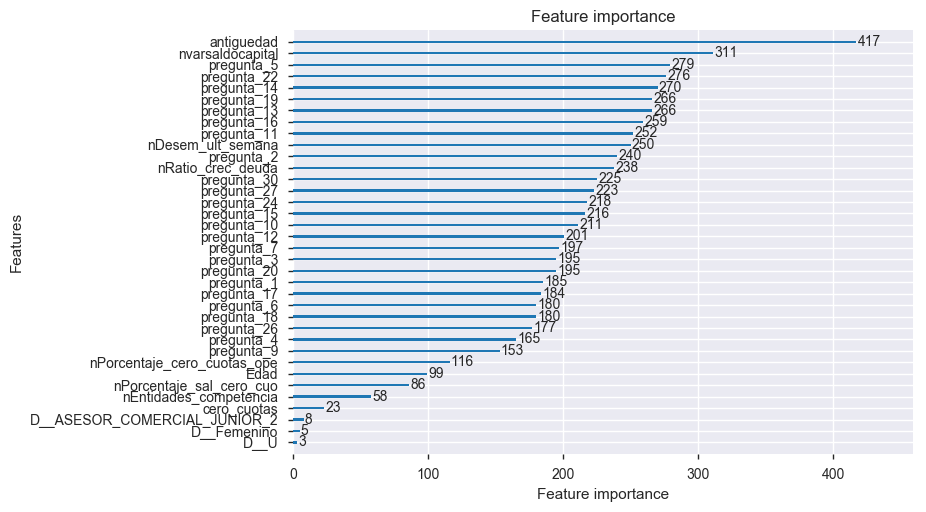

In [26]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 100,
 'n_estimators': 120}

Recall: 0.8709677419354839
Precision: 0.39705882352941174
Accuracy: 0.38461538461538464


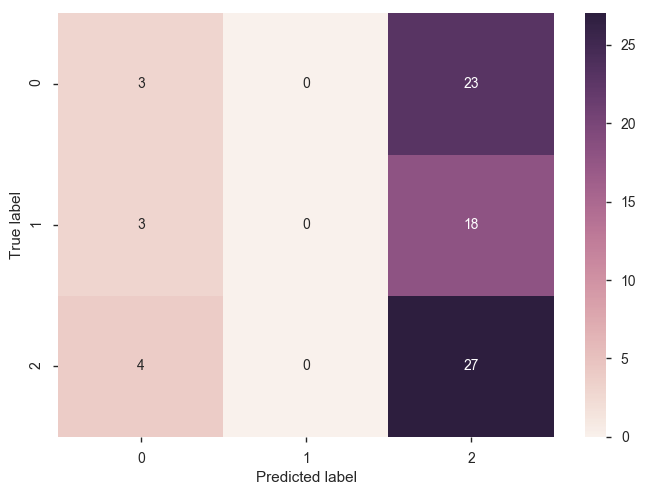

In [27]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.8709677419354839
Precision: 0.39705882352941174
Accuracy: 0.38461538461538464
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


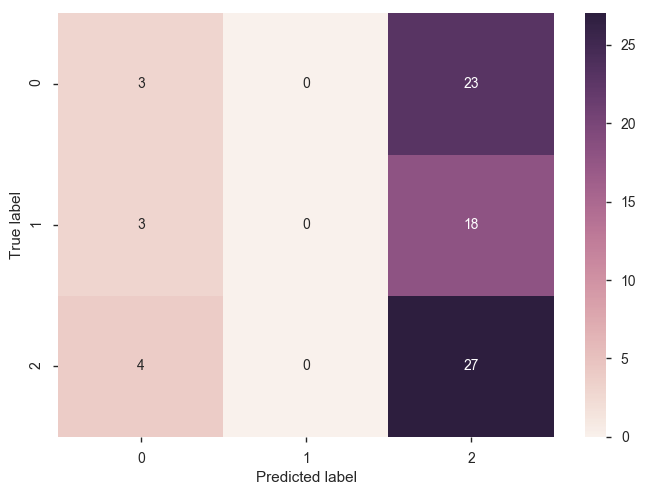

In [28]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 800}

Recall: 0.9032258064516129
Precision: 0.4745762711864407
Accuracy: 0.44871794871794873


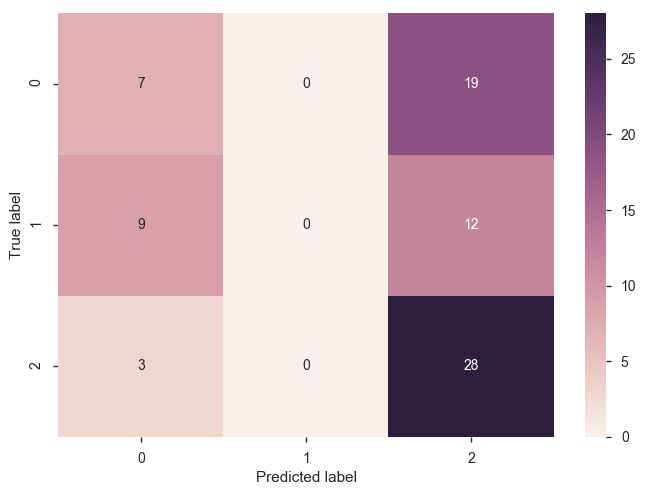

In [29]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.9032258064516129
Precision: 0.4745762711864407
Accuracy: 0.44871794871794873
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


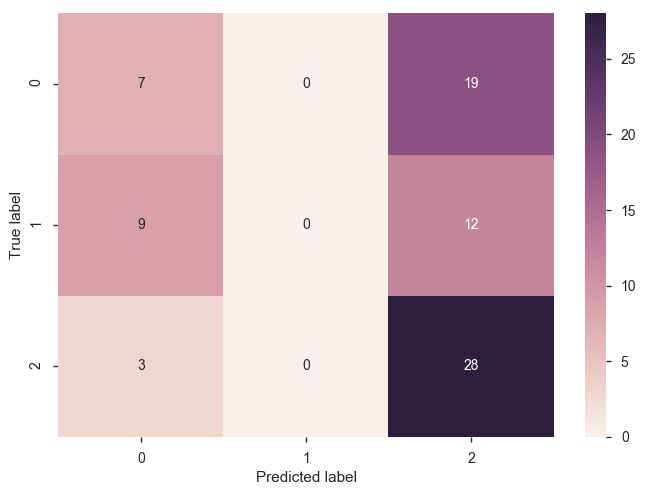

In [30]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### Garbage collection

In [34]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, clf, cluster_colors, clusterer, cm
del confusion_matrix, d, d_train, d_valid, df_categorical, df_continuous, df_discrete, df_numeric, dtc
del dtypes, estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, g, graph, hdbscan
del kf, lgb, make_correlation_graphic, model, pair_vars, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

NameError: name 'DecisionTreeClassifier' is not defined

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
cero_cuotas,0.160623,27,0.732579,0.195760,0.928339
D__ASESOR COMERCIAL JUNIOR 2,0.044189,33,0.201541,0.239262,0.440803
ingresoef,0.027319,35,0.124598,0.253763,0.378361
D__Casado,0.020265,38,0.092428,0.275514,0.367942
D__Otros,0.019610,37,0.089436,0.268264,0.357700
pregunta_30,0.037264,22,0.169957,0.159508,0.329465
cluster,0.014429,36,0.065808,0.261014,0.326821
D__U,0.010227,34,0.046645,0.246513,0.293158
pregunta_6,0.022434,26,0.102319,0.188510,0.290828
pregunta_10,0.022813,24,0.104045,0.174009,0.278054


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

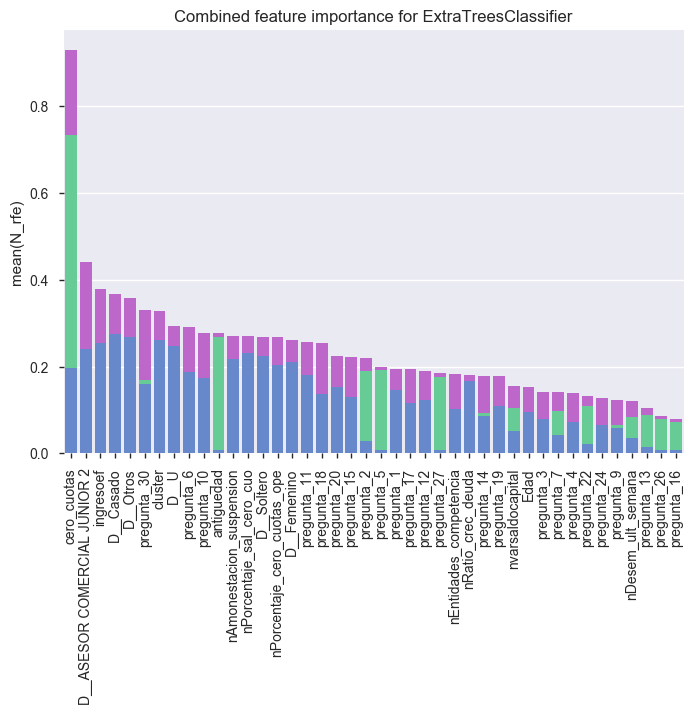

In [35]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
antiguedad,0.158544,1,0.654407,0.007250,0.661657
nvarsaldocapital,0.121273,1,0.500569,0.007250,0.507819
nPorcentaje_cero_cuotas_ope,0.040641,24,0.167749,0.174009,0.341758
nPorcentaje_sal_cero_cuo,0.028619,27,0.118128,0.195760,0.313888
cero_cuotas,0.022264,29,0.091896,0.210261,0.302157
D__Femenino,0.001112,38,0.004589,0.275514,0.280104
cluster,0.001877,36,0.007748,0.261014,0.268762
nAmonestacion_suspension,0.000000,37,0.000000,0.268264,0.268264
pregunta_11,0.017844,25,0.073654,0.181259,0.254914
pregunta_30,0.035318,15,0.145779,0.108756,0.254535


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

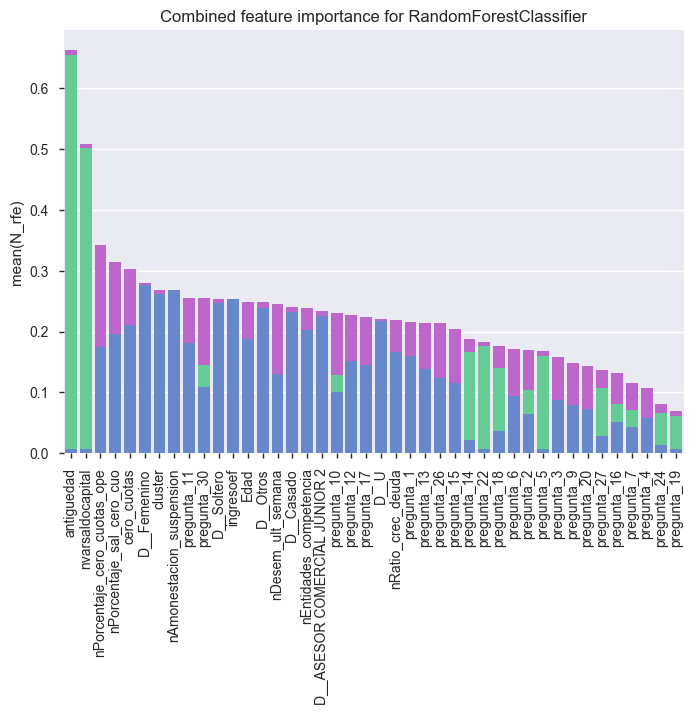

In [36]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,antiguedad,nvarsaldocapital,pregunta_5,pregunta_22,pregunta_14,pregunta_13,pregunta_19,pregunta_16,pregunta_11,nDesem_ult_semana,...,cero_cuotas,D__ASESOR_COMERCIAL_JUNIOR_2,D__Femenino,D__U,ingresoef,D__Soltero,D__Otros,D__Casado,nAmonestacion_suspension,cluster
1,417,311,279,276,270,266,266,259,252,250,...,23,8,5,3,0,0,0,0,0,0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,entropy,rfe,N_entropy,N_rfe,score
nvarsaldocapital,311,16,0.246626,0.116006,0.362632
pregunta_27,223,25,0.176841,0.181259,0.358100
antiguedad,417,1,0.330685,0.007250,0.337935
pregunta_2,240,20,0.190322,0.145008,0.335330
pregunta_26,177,24,0.140363,0.174009,0.314372
pregunta_24,218,19,0.172876,0.137757,0.310633
pregunta_18,180,23,0.142742,0.166759,0.309500
pregunta_16,259,14,0.205389,0.101505,0.306895
pregunta_19,266,11,0.210940,0.079754,0.290695
pregunta_4,165,22,0.130846,0.159508,0.290355


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

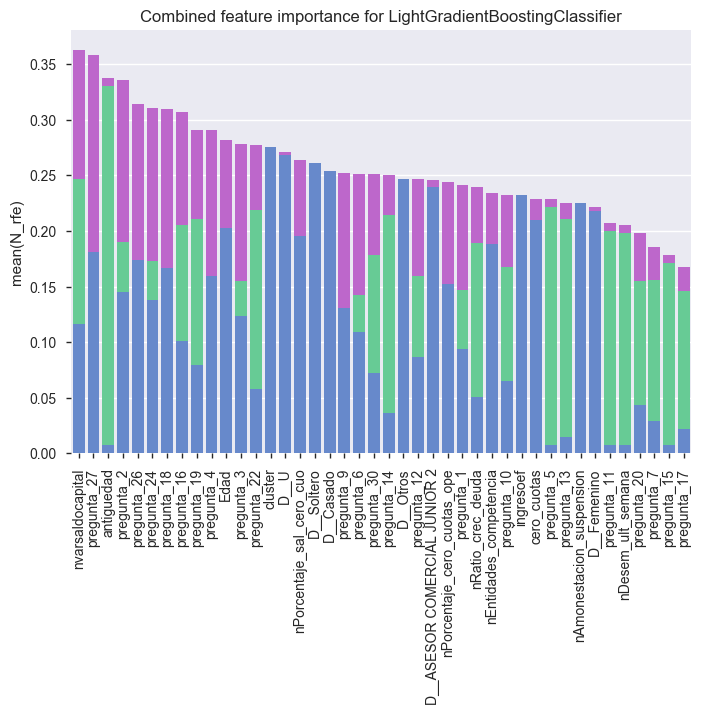

In [37]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,extra_trees,random_forest,lightgbm,score
cero_cuotas,0.928339,0.302157,0.228500,1.458997
antiguedad,0.276150,0.661657,0.337935,1.275742
nvarsaldocapital,0.154813,0.507819,0.362632,1.025264
D__ASESOR COMERCIAL JUNIOR 2,0.440803,0.234411,0.245606,0.920820
cluster,0.326821,0.268762,0.275514,0.871097
ingresoef,0.378361,0.253763,0.232012,0.864136
D__Casado,0.367942,0.239386,0.253763,0.861091
nPorcentaje_cero_cuotas_ope,0.268449,0.341758,0.244247,0.854454
D__Otros,0.357700,0.247739,0.246513,0.851953
nPorcentaje_sal_cero_cuo,0.269841,0.313888,0.263959,0.847688


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

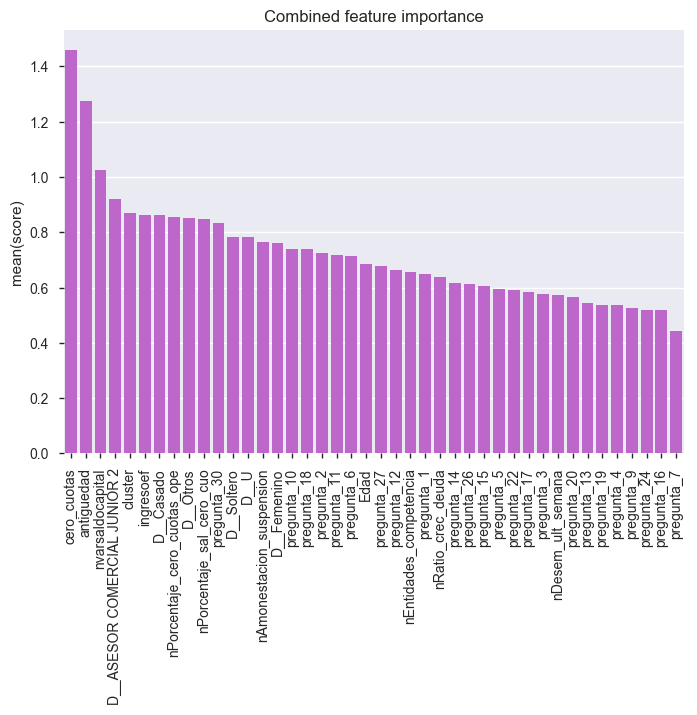

In [38]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

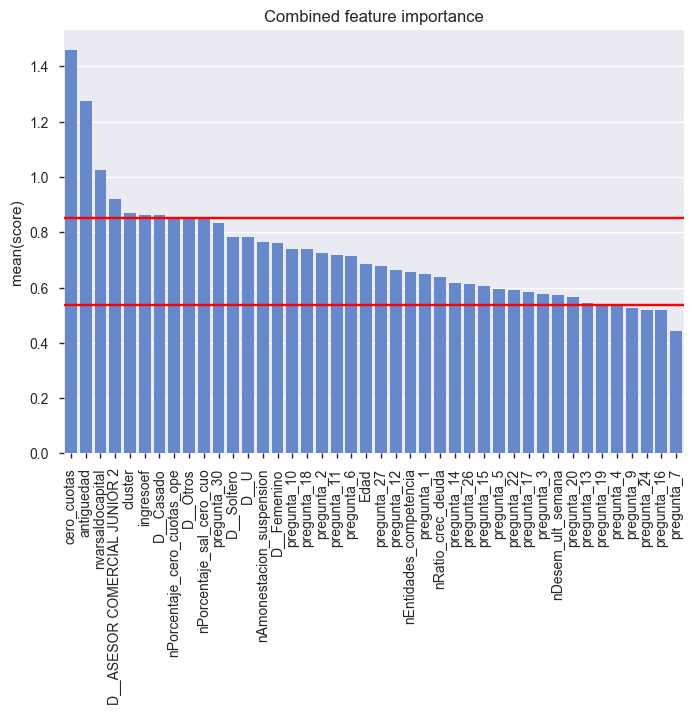

In [39]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [40]:
categories = ['bad_uncertain', 'uncertain', 'good_uncertain']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

cero_cuotas                     good_uncertain
antiguedad                      good_uncertain
nvarsaldocapital                good_uncertain
D__ASESOR COMERCIAL JUNIOR 2    good_uncertain
cluster                         good_uncertain
ingresoef                       good_uncertain
D__Casado                       good_uncertain
nPorcentaje_cero_cuotas_ope     good_uncertain
D__Otros                        good_uncertain
nPorcentaje_sal_cero_cuo             uncertain
pregunta_30                          uncertain
D__Soltero                           uncertain
D__U                                 uncertain
nAmonestacion_suspension             uncertain
D__Femenino                          uncertain
pregunta_10                          uncertain
pregunta_18                          uncertain
pregunta_2                           uncertain
pregunta_11                          uncertain
pregunta_6                           uncertain
Edad                                 uncertain
pregunta_27  

In [42]:
df_results.to_csv('uncertain_pass_results.csv')